In [1]:
import numpy as np
import pandas as pd
import utils.sulfur.constant as const

from utils.context_data_csv import ContextDataCSV
from utils.matrix_optimizer import MatrixOptimizer
from oasis.functions import deconvolve

/app/OASIS/oasis/functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


In [2]:
def droped_unique_cells(cells1, cells2):
    droped_cells = np.array([])
    droped_cells = np.append(droped_cells, cells1)
    droped_cells = np.append(droped_cells, cells2)
    droped_cells = np.unique(droped_cells)
    return droped_cells

def all_nan_cells(matrix):
    nan_cells = np.array([])
    for cell_name, items in matrix.iteritems():
        if items.isnull().all():
            nan_cells = np.append(nan_cells, cell_name)
            
    return nan_cells

def search_shock_cells(df, context_data, animal_name, context_name, std_product_element=1.0):
    shuffled_count = 1000
    threshold = 0.05
    
    upper_event_rate_cells_1 = []
    upper_event_rate_cells_2 = []
    upper_event_rate_cells_3 = []
    upper_event_rate_cells_all = []
    
    for cell_name, items in context_data.data_frame.iteritems():
        if context_data.is_engram(cell_name):
            continue
            
        items = items.astype(float)
        if items.isnull().all() or (items == 0).all():
            continue
        
        items = items.to_numpy()
        
        _c, spikes, _b, _g, _lam = deconvolve(items, g=(None, None), penalty=1)
        
        real_shock_value_1 = spikes[80:100]
        real_shock_event_rate_1 = len(real_shock_value_1[real_shock_value_1 >= threshold]) / 2.0
        
        real_shock_value_2 = spikes[980:1000]
        real_shock_event_rate_2 = len(real_shock_value_2[real_shock_value_2 >= threshold]) / 2.0
        
        real_shock_value_3 = spikes[1880:1900]
        real_shock_event_rate_3 = len(real_shock_value_3[real_shock_value_3 >= threshold]) / 2.0
        
        shuffle_event_rates = np.array([])
        for _ in range(shuffled_count):
            random_time = np.random.randint(0, len(items), size=len(items))
            shuffled_items = items[random_time]
            
            _c, spikes, _b, _g, _lam = deconvolve(shuffled_items, g=(None, None), penalty=1)
            shuffled_shock_value_1 = spikes[80:100]
            shuffled_event_rate_1 = len(shuffled_shock_value_1[shuffled_shock_value_1 >= threshold]) / 2.0
            
            shuffled_shock_value_2 = spikes[980:1000]
            shuffled_event_rate_2 = len(shuffled_shock_value_2[shuffled_shock_value_2 >= threshold]) / 2.0
            
            shuffled_shock_value_3 = spikes[1880:1900]
            shuffled_event_rate_3 = len(shuffled_shock_value_3[shuffled_shock_value_3 >= threshold]) / 2.0
            
            shuffle_summary = np.array([shuffled_event_rate_1, shuffled_event_rate_2, shuffled_event_rate_3])
            
            shuffle_event_rates = np.append(shuffle_event_rates, np.mean(shuffle_summary))
            
        shuffle_mean = np.mean(shuffle_event_rates)
        shuffle_std = np.std(shuffle_event_rates)
        
        threshold_event_rate = shuffle_mean + (shuffle_std * std_product_element)
        if threshold_event_rate <= real_shock_event_rate_1:
            upper_event_rate_cells_1.append(cell_name)
            
        if threshold_event_rate <= real_shock_event_rate_2:
            upper_event_rate_cells_2.append(cell_name)
            
        if threshold_event_rate <= real_shock_event_rate_3:
            upper_event_rate_cells_3.append(cell_name)
            
        if threshold_event_rate <= real_shock_event_rate_1 and threshold_event_rate <= real_shock_event_rate_2 and threshold_event_rate <= real_shock_event_rate_3:
            upper_event_rate_cells_all.append(cell_name)
        
    all_size = len(context_data.data_frame.columns)
    non_engram_cell_size = len(context_data.non_engram_cells())
    count = 0
    df.loc[animal_name, '%s_1' % context_name] = len(upper_event_rate_cells_1) / non_engram_cell_size
    df.loc[animal_name, '%s_2' % context_name] = len(upper_event_rate_cells_2) / non_engram_cell_size
    df.loc[animal_name, '%s_3' % context_name] = len(upper_event_rate_cells_3) / non_engram_cell_size
    df.loc[animal_name, '%s_all' % context_name] = len(upper_event_rate_cells_all) / non_engram_cell_size
    
    return upper_event_rate_cells_all

In [3]:
index = const.ANIMAL_NAMES
columns = ['A1_1', 'A1_2', 'A1_3', 'A1_all', 'A4_1', 'A4_2', 'A4_3', 'A4_all', 'across_all']
df_2sd = pd.DataFrame(index=index, columns=columns)

for animal_name in const.ANIMAL_NAMES:
    print('animal name: %s' % animal_name)
    
    a1_csv = ContextDataCSV(animal_name, 'A1postES')
    a1_matrix = a1_csv.data_frame
    a1_matrix = MatrixOptimizer(a1_matrix).divide_sd()
    
    a4_csv = ContextDataCSV(animal_name, 'A4postES')
    a4_matrix = a4_csv.data_frame
    a4_matrix = MatrixOptimizer(a4_matrix).divide_sd()

    a1_nan_cells = all_nan_cells(a1_matrix)
    a4_nan_cells = all_nan_cells(a4_matrix)
    
    droped_cells = droped_unique_cells(a1_nan_cells, a4_nan_cells)
    a1_matrix.drop(columns=droped_cells, inplace=True)
    a4_matrix.drop(columns=droped_cells, inplace=True)
    
    a1_all_cells = search_shock_cells(df_2sd, a1_csv, animal_name, 'A1', std_product_element=2.0)
    a4_all_cells = search_shock_cells(df_2sd, a4_csv, animal_name, 'A4', std_product_element=2.0)
    
    all_cells = []
    print(a1_all_cells)
    print(a4_all_cells)
    for cell_name in a1_all_cells:
        if cell_name in a4_all_cells:
            all_cells.append(cell_name)
            
    print(all_cells)
    df_2sd.loc[animal_name, 'across_all'] = len(all_cells) / len(a1_csv.non_engram_cells())

df_2sd

animal name: ID181106CreA
['C000', 'C001', 'C007', 'C009', 'C010', 'C013', 'C014', 'C015', 'C019', 'C032', 'C036', 'C058', 'C059', 'C063', 'C076', 'C084', 'C086', 'C090', 'C097', 'C099', 'C100', 'C101', 'C102', 'C115', 'C116', 'C117', 'C118', 'C119', 'C120', 'C124', 'C128', 'C136', 'C137', 'C138', 'C141', 'C142', 'C143', 'C144', 'C145', 'C148', 'C153', 'C154', 'C160', 'C162', 'C164', 'C165', 'C166', 'C167', 'C170', 'C173', 'C175', 'C178', 'C181', 'C183', 'C186', 'C187', 'C190', 'C194', 'C196', 'C197', 'C198', 'C205', 'C208', 'C218', 'C219', 'C221', 'C226', 'C228', 'C231', 'C234', 'C235', 'C236', 'C238', 'C240', 'C242', 'C243', 'C247', 'C258', 'C263', 'C266', 'C267', 'C268', 'C270', 'C273', 'C274', 'C277', 'C279', 'C280', 'C282', 'C284', 'C285', 'C286', 'C287', 'C303', 'C304', 'C306', 'C310', 'C311', 'C313', 'C317', 'C319', 'C322', 'C323', 'C324', 'C325', 'C327', 'C328', 'C329', 'C331', 'C333', 'C335', 'C336', 'C339', 'C353', 'C354', 'C356', 'C361', 'C362', 'C365', 'C366', 'C367', 'C370

['C000', 'C010', 'C011', 'C012', 'C018', 'C020', 'C021', 'C022', 'C038', 'C041', 'C043', 'C046', 'C051', 'C059', 'C061', 'C064', 'C067', 'C070', 'C073', 'C074', 'C081', 'C082', 'C083', 'C085', 'C087', 'C125', 'C127', 'C128', 'C129', 'C130', 'C139', 'C144', 'C146', 'C148', 'C160', 'C172', 'C173', 'C175', 'C176', 'C183', 'C193', 'C194', 'C202', 'C203', 'C214', 'C218', 'C224', 'C231', 'C232', 'C249', 'C250', 'C251', 'C252', 'C256', 'C258', 'C261', 'C262', 'C268', 'C271', 'C274', 'C278', 'C280', 'C286', 'C288', 'C296', 'C297', 'C303', 'C310', 'C313', 'C322', 'C328', 'C329', 'C330', 'C338', 'C350', 'C353', 'C355', 'C360', 'C361', 'C375', 'C385', 'C386', 'C393', 'C395', 'C397', 'C398', 'C400', 'C404', 'C406', 'C411', 'C416', 'C427', 'C430', 'C433', 'C450', 'C464', 'C468', 'C475', 'C485', 'C489', 'C490', 'C493', 'C497', 'C498', 'C504', 'C505', 'C511', 'C514', 'C517', 'C518', 'C520', 'C521', 'C525', 'C528', 'C529', 'C536', 'C541', 'C543', 'C544', 'C545', 'C550', 'C551', 'C553', 'C556', 'C561',

['C002', 'C006', 'C008', 'C009', 'C011', 'C014', 'C016', 'C017', 'C018', 'C019', 'C020', 'C022', 'C028', 'C034', 'C035', 'C036', 'C037', 'C043', 'C044', 'C048', 'C049', 'C052', 'C054', 'C057', 'C058', 'C060', 'C062', 'C063', 'C064', 'C069', 'C071', 'C072', 'C074', 'C079', 'C082', 'C085', 'C088', 'C089', 'C091', 'C094', 'C095', 'C097', 'C098', 'C101', 'C103', 'C104', 'C106', 'C107', 'C109', 'C110', 'C111', 'C112', 'C117', 'C119', 'C120', 'C123', 'C132', 'C135', 'C139', 'C141', 'C142', 'C144', 'C148', 'C149', 'C154', 'C156', 'C157', 'C163', 'C166', 'C167', 'C168', 'C169', 'C172', 'C177', 'C178', 'C182', 'C186', 'C191', 'C200', 'C201', 'C204', 'C210', 'C211', 'C213', 'C214', 'C216', 'C217', 'C221', 'C227', 'C228', 'C230', 'C233', 'C235', 'C236', 'C239', 'C240', 'C243', 'C248', 'C249', 'C252', 'C254', 'C261', 'C267', 'C269', 'C274', 'C276', 'C278', 'C279', 'C284', 'C285', 'C286', 'C288', 'C290', 'C295', 'C301', 'C303', 'C306', 'C309', 'C313', 'C314', 'C315', 'C316', 'C321', 'C324', 'C326',

,A1_1,A1_2,A1_3,A1_all,A4_1,A4_2,A4_3,A4_all,across_all
ID181106CreA,0.36338,0.34507,0.359155,0.223944,0.325352,0.305634,0.342254,0.177465,0.06338
ID181106CreB,0.372396,0.424479,0.445312,0.289062,0.416667,0.395833,0.455729,0.294271,0.106771
ID181106CreC,0.435096,0.449519,0.432692,0.326923,0.5,0.475962,0.478365,0.372596,0.149038
ID181106CreG,0.380223,0.369081,0.387187,0.229805,0.388579,0.377437,0.388579,0.228412,0.083565
ID181106CreH,0.322888,0.310627,0.358311,0.209809,0.320163,0.332425,0.317439,0.205722,0.064033
ID181106CreI,0.336516,0.236277,0.27685,0.159905,0.336516,0.310263,0.326969,0.217184,0.052506
ID181106CreK,0.44386,0.377193,0.429825,0.247368,0.463158,0.454386,0.459649,0.294737,0.077193
ID181106CreL,0.403462,0.45273,0.420772,0.292943,0.364847,0.407457,0.396804,0.23036,0.089214
ID181106CreN,0.349188,0.337587,0.338747,0.227378,0.392111,0.392111,0.37239,0.259861,0.058005
ID181106CreQ,0.500773,0.514683,0.499227,0.363215,0.431221,0.459042,0.423493,0.272025,0.122102


In [4]:
df_2sd.mean()

A1_1          0.390778
A1_2          0.381725
A1_3          0.394808
A1_all        0.257035
A4_1          0.393861
A4_2          0.391055
A4_3          0.396167
A4_all        0.255263
across_all    0.086581
dtype: float64

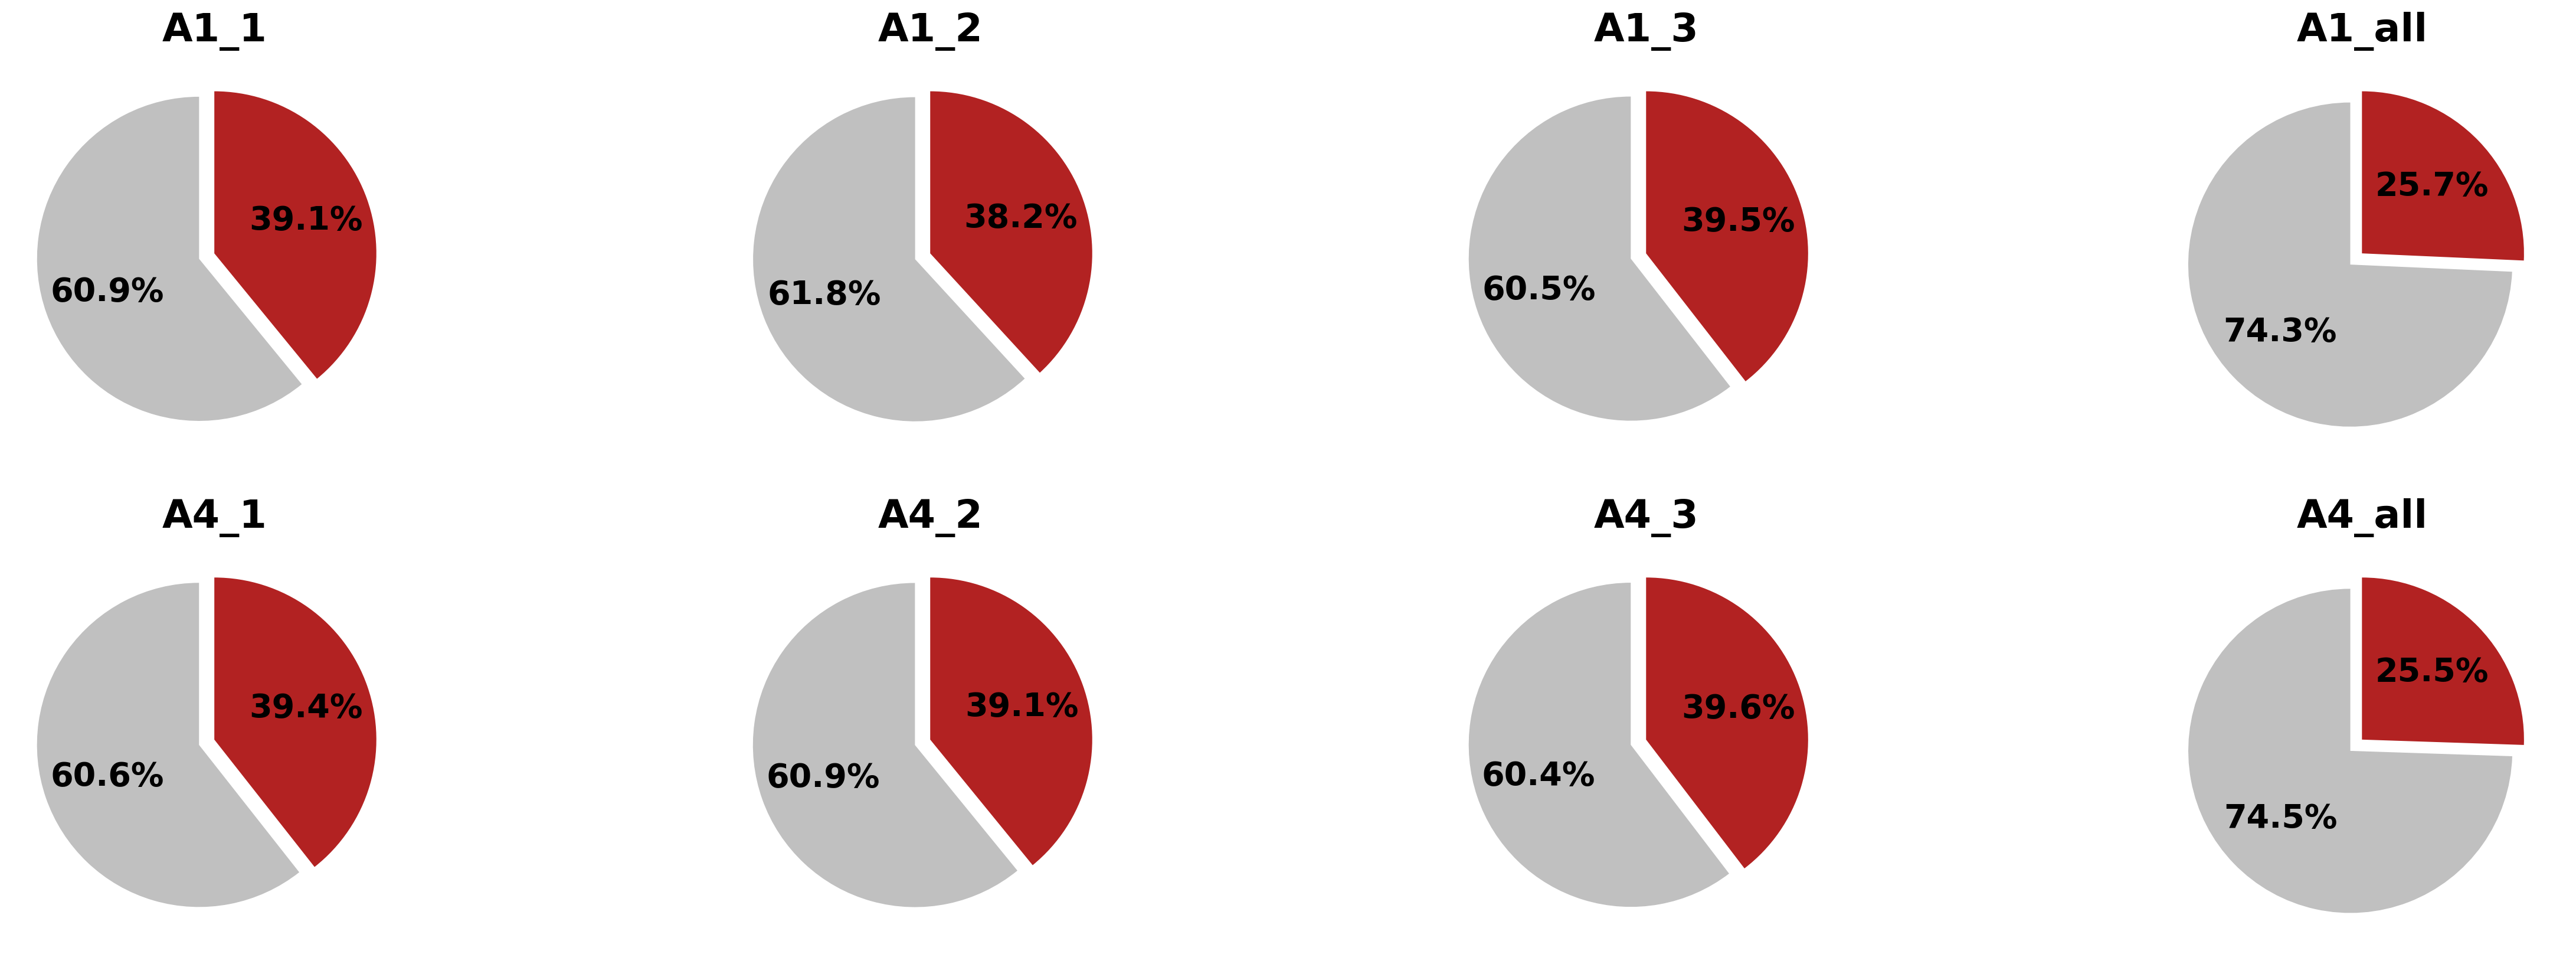

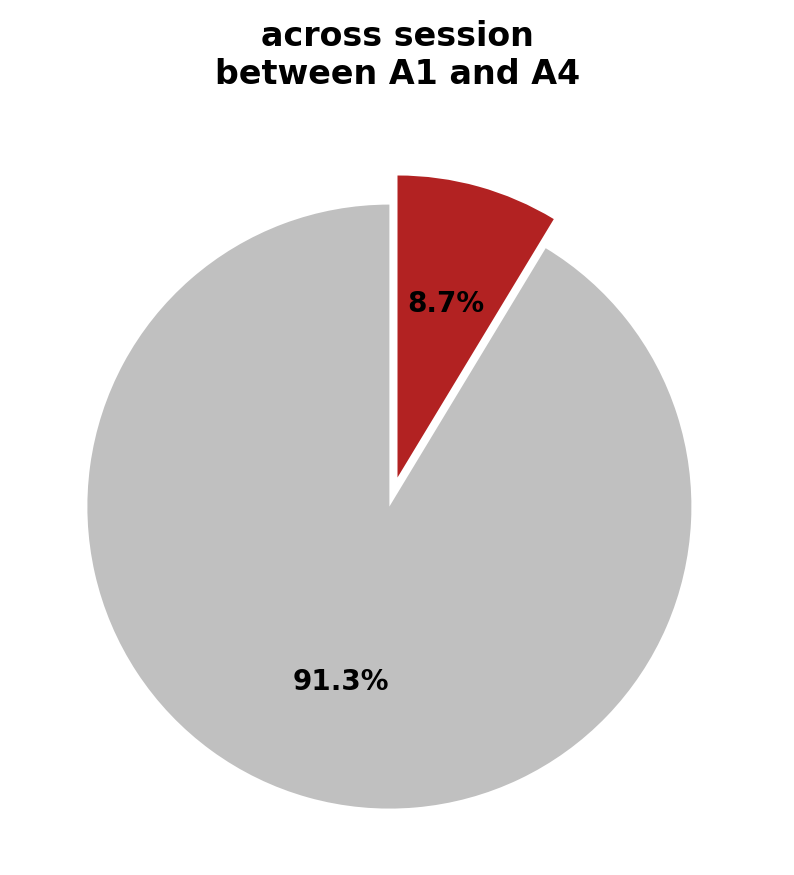

In [6]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=4, nrows=2, dpi=200, figsize=(30, 10))
row_number = -1
means = df_2sd.mean()
for i, context_name in enumerate(means.index[:-1]):
    index = i % 4
    if index == 0:
        row_number += 1
    
    shock_rate = means[context_name]
    non_shock_rate = 1.0 - shock_rate
    ax = axes[row_number][index]
    ax.pie([non_shock_rate, shock_rate], 
            startangle=90,
            autopct="%1.1f%%", 
            explode=[0.1, 0],
            textprops={'color': 'black', 'weight': 'bold', 'size': 20},
            colors=['silver', 'firebrick']
                               )
    ax.set_title(context_name, fontsize=24, fontweight='bold')
    
fig.show()

fig, ax = plt.subplots(dpi=200, figsize=(5, 5))
across_shock_rate = means['across_all']
across_non_shock_rate = 1.0 - across_shock_rate
ax.pie([across_non_shock_rate, across_shock_rate], 
            startangle=90,
            autopct="%1.1f%%", 
            explode=[0.1, 0],
            textprops={'color': 'black', 'weight': 'bold'},
            colors=['silver', 'firebrick']
      )
ax.set_title('across session\nbetween A1 and A4', fontweight='bold')
fig.show()